Source: This example comes from the torch adaptation of Charles Ollion [/github/charlesollion].

In [200]:

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

Data Acquisition

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#DATA LOADING
df = pd.read_csv("AAPL_2006-01-01_to_2018-01-01.csv")
df = df.drop(columns=["Name"])

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

print(df.head())

X = df.values


             Open   High    Low  Close     Volume
Date                                             
2006-01-03  10.34  10.68  10.32  10.68  201853036
2006-01-04  10.73  10.85  10.64  10.71  155225609
2006-01-05  10.69  10.70  10.54  10.63  112396081
2006-01-06  10.75  10.96  10.65  10.90  176139334
2006-01-09  10.96  11.03  10.82  10.86  168861224


Function for splitting the dataset into sequences of observations of length history size.

In [202]:
def sequencing(dataset, start_index=0, end_index=None, history_size=13, step=1):
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)


Function for splitting the dataset into training and validation, and data normalization.

In [203]:
def partition(data, pTrain=0.7, pVal = 0.5, save_path=None):
    # I don't like this normalization before training thingie
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean)/data_std
    stats = (data_mean, data_std)

    sequencedData = sequencing(data, start_index=0, end_index=None, history_size=13, step=1)

    dataTrain, dataVal = train_test_split(sequencedData, train_size=pTrain, shuffle=True, random_state=123)
    dataVal, dataTest = train_test_split(dataVal, train_size=pVal, shuffle=True, random_state=123)

    return dataTrain, dataVal, dataTest

Create input-putput pairs.

In [204]:
def split(chunk):
    inputs = torch.tensor(chunk[:, :-1, :], dtype=torch.float32, device=device)
    targets = torch.tensor(chunk[:, 1:, :], dtype=torch.float32, device=device)

    return inputs, targets

device = "mps" if torch.backends.mps.is_available() else torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaders

In [205]:
def createLoaders(dataTrain, dataVal, dataTest, batchSize=32, responseVariables=list(range(5))):
    XTrain, YTrain = split(dataTrain)
    XVal, YVal = split(dataVal)
    XTest, YTest = split(dataTest)

    YTrain = YTrain[:,:,responseVariables]
    YVal = YVal[:,:,responseVariables]
    YTest = YTest[:,:,responseVariables]

    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)

    return trainLoader, valLoader, testLoader

trainData, valData, testData = partition(X)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData)

Transformer NN implementation

In [206]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [207]:
B, S, H, D = 9, 11, 5, 8
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 11, 8]), torch.Size([9, 5, 11, 11]))

In [208]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=2000, dim=3, device=device):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis].astype(np.float32),
        np.arange(D)[np.newaxis, :].astype(np.float32),
        D
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis, np.newaxis, ...]

    # Convert to float32 Tensor
    return torch.tensor(pos_encoding, dtype=torch.float32, device=device)


# function that implement the look_ahead mask for masking future time steps. 
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)

create_look_ahead_mask(6)

class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):
        
        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        
        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [209]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [210]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, 
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D
        
        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block
        
        x = self.output_projection(x)
        
        return x, attention_weights # (B,S,S)

In [211]:
# Test Forward pass on the Transformer: 
transformer = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=5, out_features=5, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(trainDataset))
                         
S = inputs.shape[1]
mask = create_look_ahead_mask(S)
out, attn = transformer (x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

(torch.Size([32, 12, 5]), torch.Size([32, 1, 12, 12]))

Training the Transformer

In [212]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 6821 parameters 


In [213]:
transformer = Transformer(num_layers=1, D=32, H=4, hidden_mlp_dim=32,
                          inp_features=5, out_features=5, dropout_rate=0.1).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(), 
                                lr=0.00005)

In [214]:
from tqdm import tqdm

n_epochs = 20
losses, val_losses = [], []

for e in range(n_epochs):
    # TRAINING
    transformer.train()
    sum_train_loss = 0.0
    for x, y in trainDataset:

        # Create proper look-ahead mask
        S = x.shape[1]
        mask = create_look_ahead_mask(S).unsqueeze(0).unsqueeze(0).to(device)

        # Forward pass
        out, _ = transformer(x, mask)

        # Loss
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(sum_train_loss / len(trainDataset))

    # VALIDATION
    transformer.eval()
    sum_val_loss = 0.0
    with torch.no_grad():
        for x, y in valDataset:

            S = x.shape[1]
            mask = create_look_ahead_mask(S).unsqueeze(0).unsqueeze(0).to(device)

            out, _ = transformer(x, mask)
            loss = torch.nn.MSELoss()(out, y)
            sum_val_loss += loss.item()

    val_losses.append(sum_val_loss / len(valDataset))

    print(f"Epoch {e+1}/{n_epochs} | Train Loss: {losses[-1]:.6f} | Val Loss: {val_losses[-1]:.6f}")


Epoch 1/20 | Train Loss: 0.788490 | Val Loss: 0.363030
Epoch 2/20 | Train Loss: 0.371665 | Val Loss: 0.191452
Epoch 3/20 | Train Loss: 0.257969 | Val Loss: 0.142212
Epoch 4/20 | Train Loss: 0.213629 | Val Loss: 0.123030
Epoch 5/20 | Train Loss: 0.189354 | Val Loss: 0.110342
Epoch 6/20 | Train Loss: 0.171590 | Val Loss: 0.099735
Epoch 7/20 | Train Loss: 0.156509 | Val Loss: 0.090313
Epoch 8/20 | Train Loss: 0.144417 | Val Loss: 0.083066
Epoch 9/20 | Train Loss: 0.134733 | Val Loss: 0.077008
Epoch 10/20 | Train Loss: 0.124412 | Val Loss: 0.072561
Epoch 11/20 | Train Loss: 0.117121 | Val Loss: 0.068512
Epoch 12/20 | Train Loss: 0.110403 | Val Loss: 0.065658
Epoch 13/20 | Train Loss: 0.105037 | Val Loss: 0.063415
Epoch 14/20 | Train Loss: 0.099513 | Val Loss: 0.060876
Epoch 15/20 | Train Loss: 0.096434 | Val Loss: 0.059340
Epoch 16/20 | Train Loss: 0.092159 | Val Loss: 0.057835
Epoch 17/20 | Train Loss: 0.089131 | Val Loss: 0.056613
Epoch 18/20 | Train Loss: 0.085878 | Val Loss: 0.055319
E

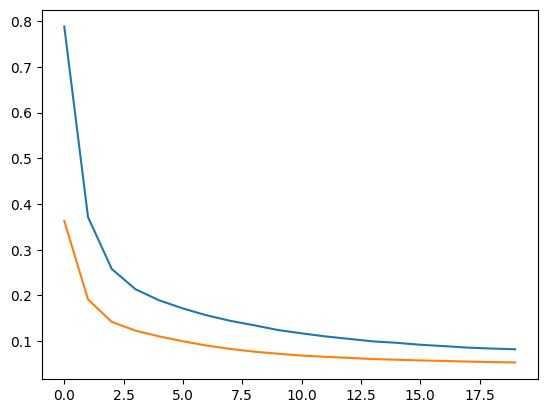

In [215]:
plt.plot(losses)
plt.plot(val_losses)

In [216]:
# Evaluate on test data
transformer.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in testDataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S).unsqueeze(0).unsqueeze(0).to(device)
        preds, _ = transformer(x, mask)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Convert to arrays
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

print(all_preds.shape, all_targets.shape)

(451, 12, 5) (451, 12, 5)


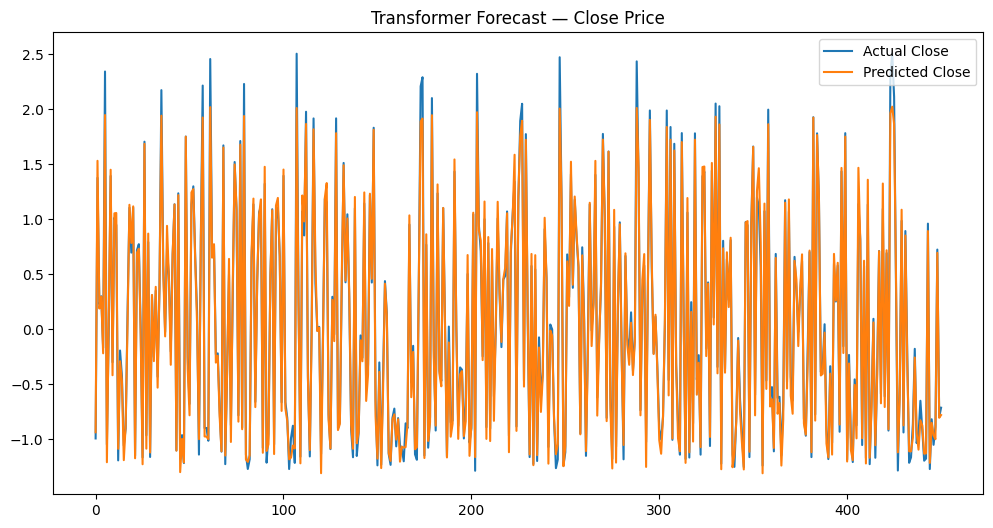

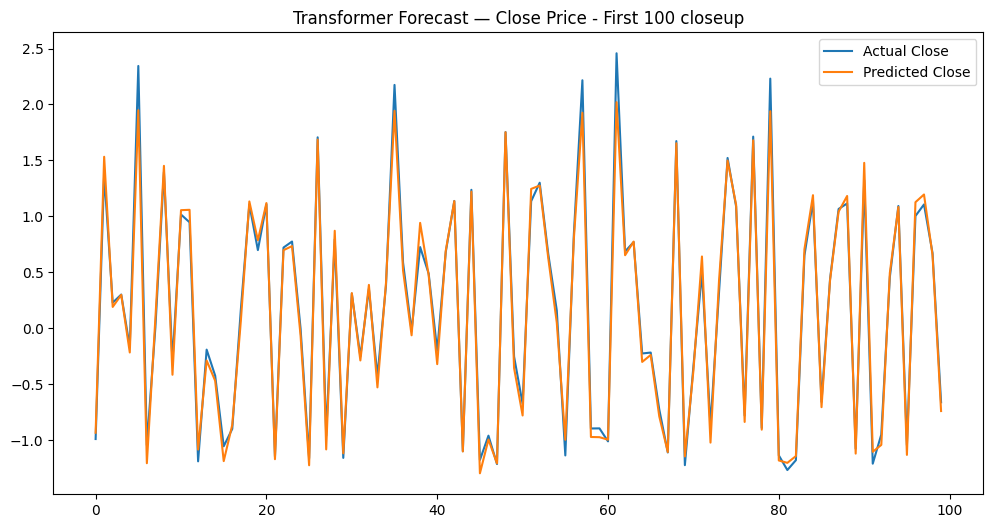

In [217]:
import matplotlib.pyplot as plt

feature_idx = 3  # Close price

plt.figure(figsize=(12,6))
plt.plot(all_targets[:, -1, feature_idx], label="Actual Close")
plt.plot(all_preds[:, -1, feature_idx], label="Predicted Close")
plt.title("Transformer Forecast — Close Price")
plt.legend()
plt.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(all_targets[:100, -1, feature_idx], label="Actual Close")
plt.plot(all_preds[:100, -1, feature_idx], label="Predicted Close")
plt.title("Transformer Forecast — Close Price - First 100 closeup")
plt.legend()
plt.show()

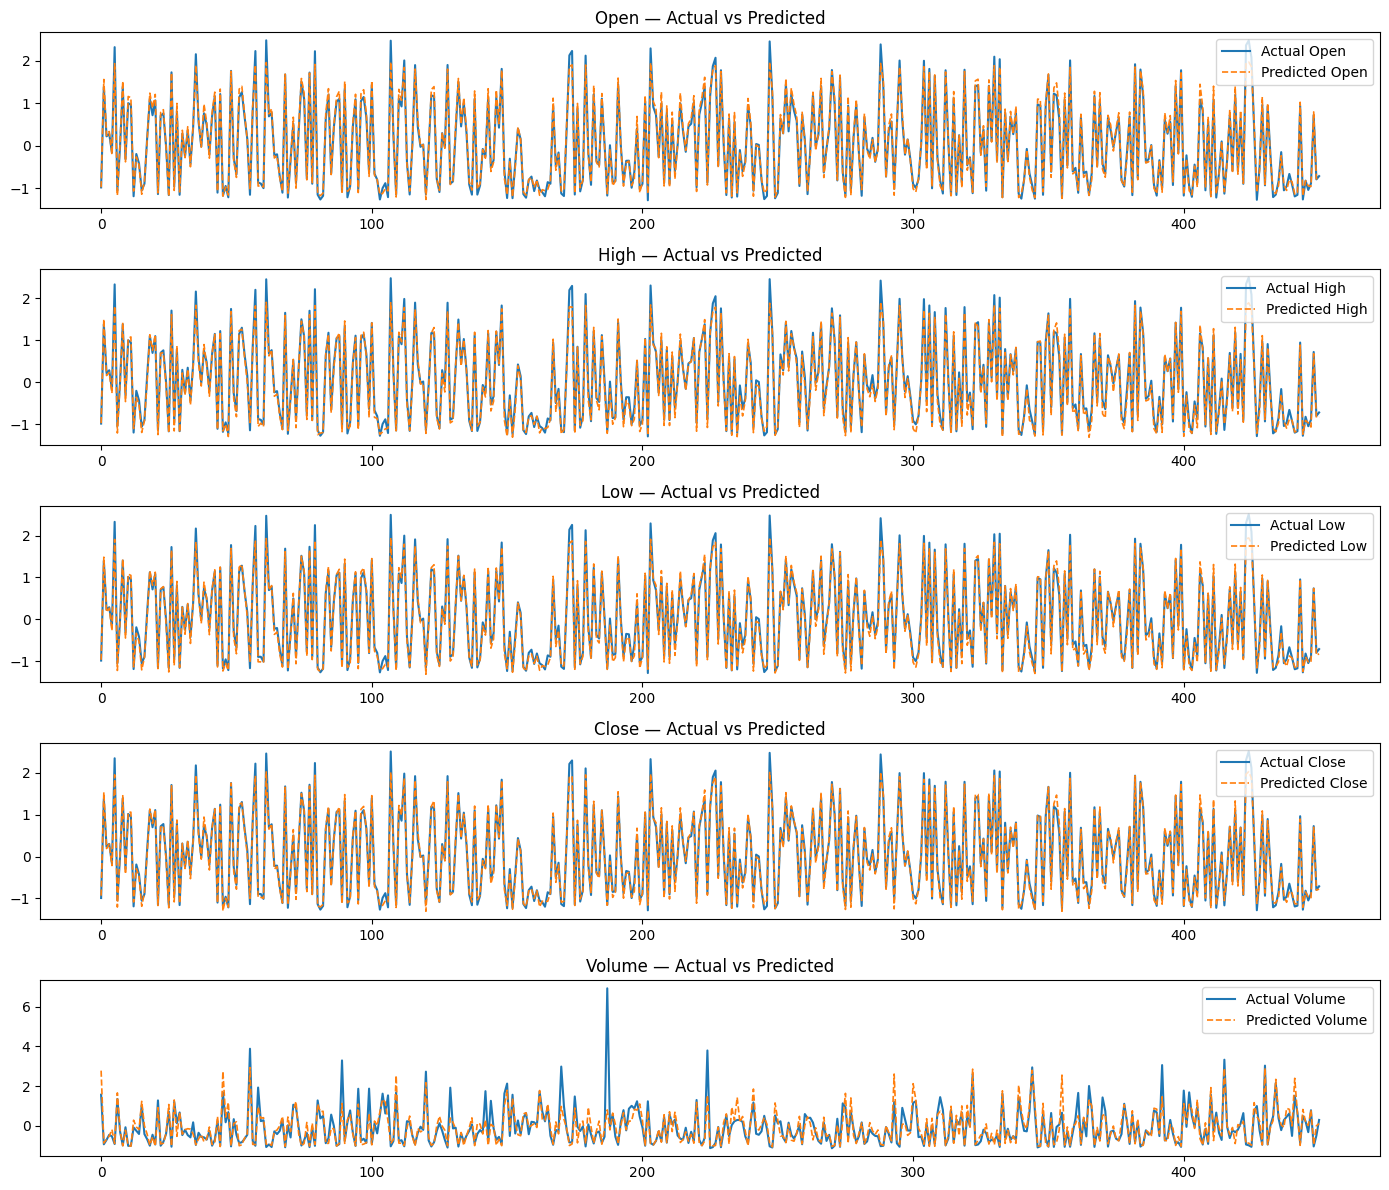

In [218]:
import matplotlib.pyplot as plt

feature_names = ["Open", "High", "Low", "Close", "Volume"]

plt.figure(figsize=(14, 12))

for i, name in enumerate(feature_names):
    plt.subplot(5, 1, i+1)
    plt.plot(all_targets[:, -1, i], label=f"Actual {name}", linewidth=1.5)
    plt.plot(all_preds[:, -1, i], label=f"Predicted {name}", linestyle="--", linewidth=1.2)
    plt.title(f"{name} — Actual vs Predicted")
    plt.legend()
    plt.tight_layout()

plt.show()


In [219]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

for i, name in enumerate(feature_names):
    actual = all_targets[:, -1, i]
    pred = all_preds[:, -1, i]
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))

    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}")


Open: MAE=0.0954, RMSE=0.1241
High: MAE=0.1011, RMSE=0.1378
Low: MAE=0.0957, RMSE=0.1277
Close: MAE=0.0805, RMSE=0.1102
Volume: MAE=0.2822, RMSE=0.5072


(451, 5) (451, 5)


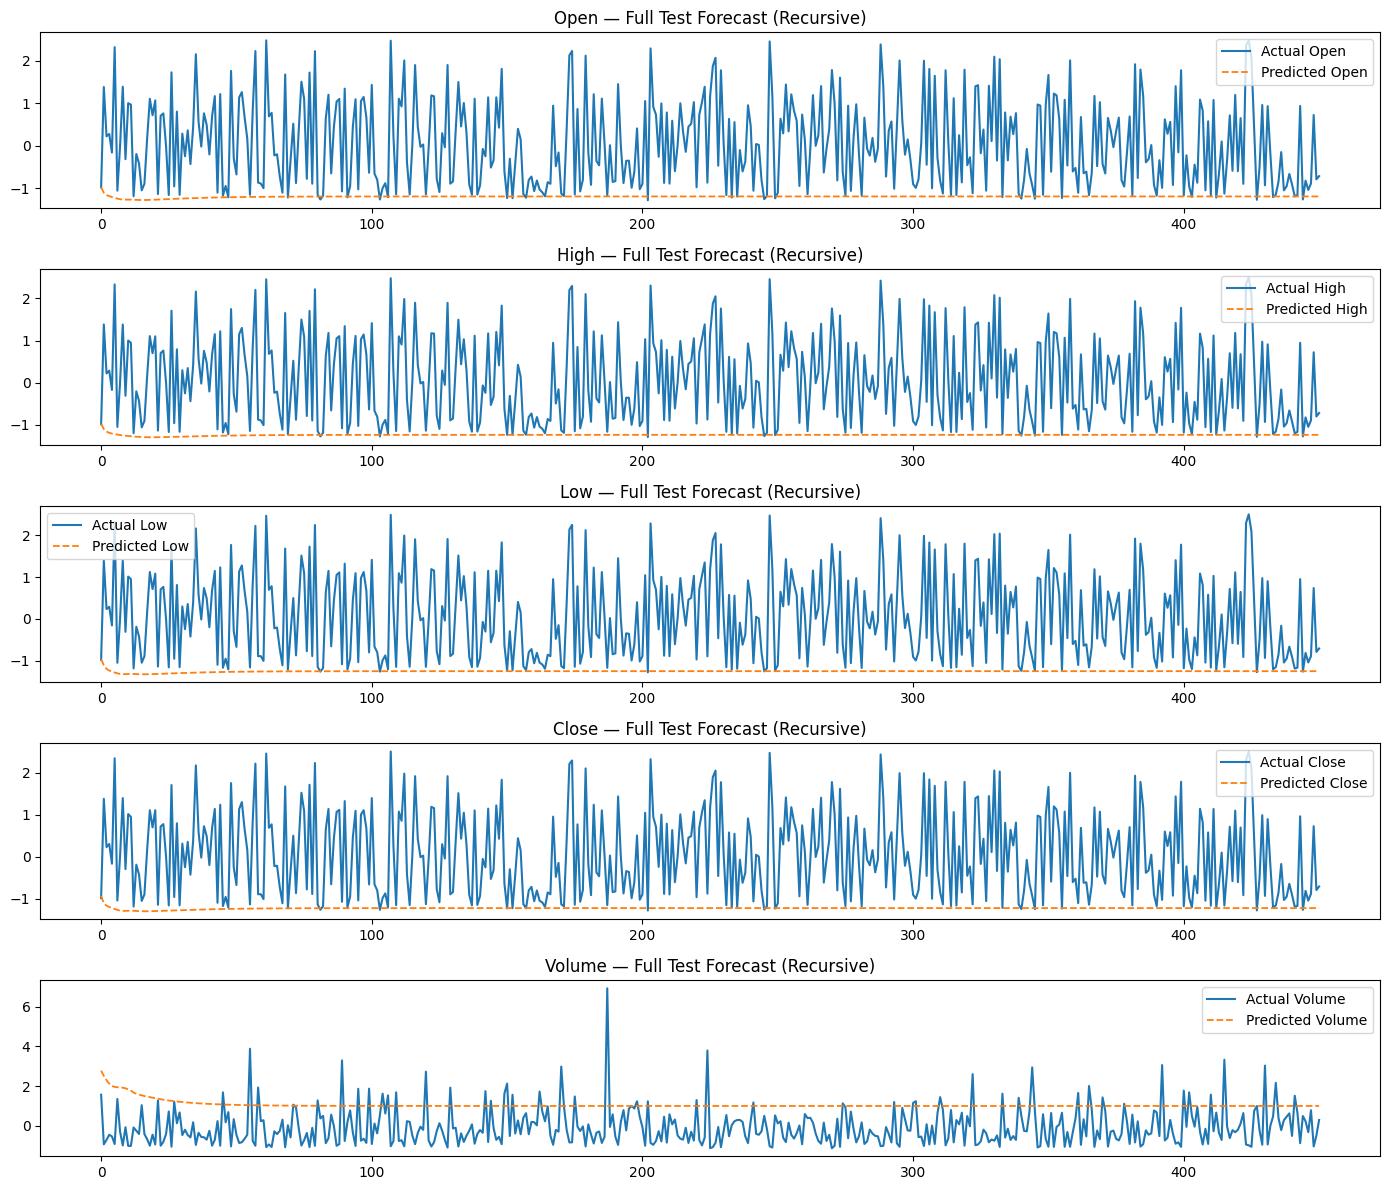

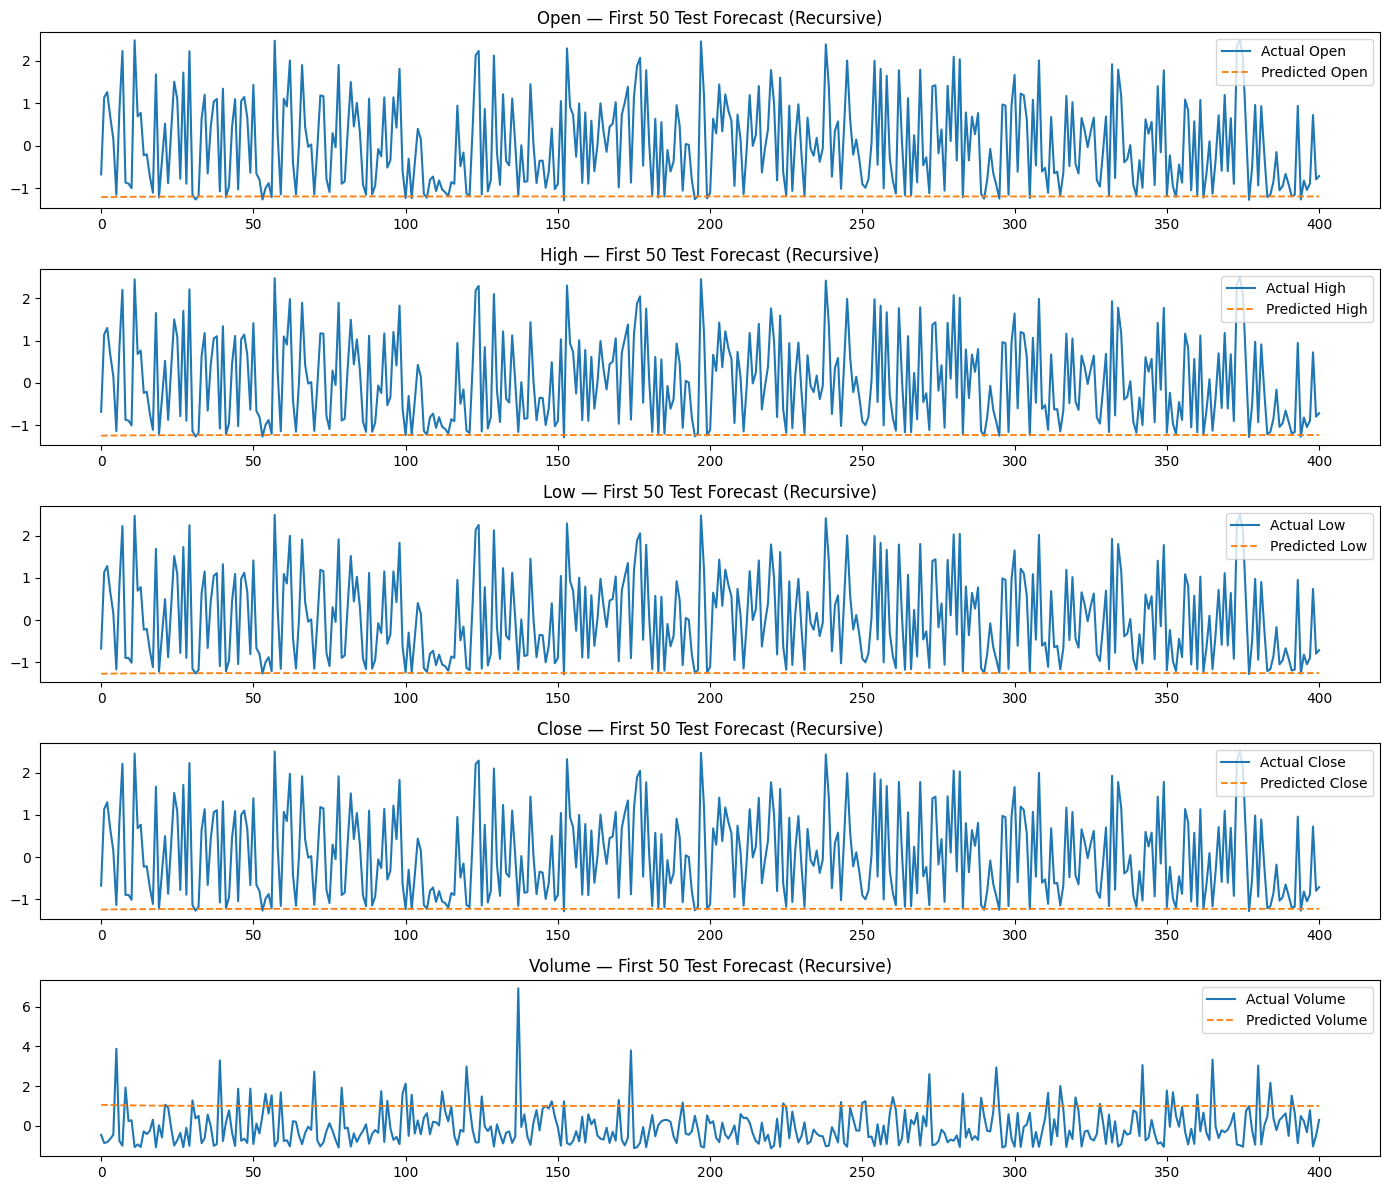

In [226]:
transformer.eval()

x_test, y_test = next(iter(testDataset))

# Sequence length and feature count
S = x_test.shape[1]
F = x_test.shape[2]

seed_input = x_test[0:1].clone().to(device)   # shape: (1, S, F)

real_test = []

for bx, by in testDataset:
    real_test.append(by.cpu().numpy())

real_test = np.concatenate(real_test, axis=0)   # shape: (N_test, S, F)

N_test = real_test.shape[0]   # how many predictions you need

preds = []

input_seq = seed_input.clone()  # rolling window

with torch.no_grad():
    for _ in range(N_test):

        S_current = input_seq.shape[1]
        mask = create_look_ahead_mask(S_current).unsqueeze(0).unsqueeze(0).to(device)

        output, _ = transformer(input_seq, mask)

        next_step = output[:, -1:, :]             # (1, 1, F)
        preds.append(next_step.detach().cpu().numpy())

        input_seq = torch.cat([input_seq[:, 1:, :], next_step], dim=1)

preds = np.concatenate(preds, axis=0)        # (N_test, 1, F)
preds = preds[:, 0, :]                       # (N_test, F)

real = real_test[:, -1, :]                   # (N_test, F)

print(preds.shape, real.shape)


feature_names = ["Open", "High", "Low", "Close", "Volume"]

plt.figure(figsize=(14,12))

for i, name in enumerate(feature_names):
    plt.subplot(5, 1, i+1)
    plt.plot(real[:, i], label=f"Actual {name}", linewidth=1.5)
    plt.plot(preds[:, i], "--", label=f"Predicted {name}", linewidth=1.3)
    plt.title(f"{name} — Full Test Forecast (Recursive)")
    plt.legend()
    plt.tight_layout()

plt.show()

plt.figure(figsize=(14,12))

for i, name in enumerate(feature_names):
    plt.subplot(5, 1, i+1)
    plt.plot(real[50:, i], label=f"Actual {name}", linewidth=1.5)
    plt.plot(preds[50:, i], "--", label=f"Predicted {name}", linewidth=1.3)
    plt.title(f"{name} — First 50 Test Forecast (Recursive)")
    plt.legend()
    plt.tight_layout()

plt.show()